# Improving GAN Outputs with Class Conditioning
Submitted by: Rishabh Kaushick
<br>
Date: March 2, 2025

# Table of Contents:
-----

# Environment Setup
- Install the necessary libraries (e.g., TensorFlow or PyTorch, NumPy, Matplotlib).
- Verify that the Fashion MNIST dataset can be successfully loaded using your chosen framework.
- Document your environment setup (e.g., software versions, hardware used).

In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import torchvision.models as models
import numpy as np
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import pandas as pd
import seaborn as sns

## Harware Requirements
### CUDA: GPU Availability

In [2]:
 
print(f"PyTorch version: {torch.__version__}")
print(f"Is CUDA available: {torch.cuda.is_available()}")
 
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"cuDNN version: {torch.backends.cudnn.version()}")
    print(f"cuDNN enabled: {torch.backends.cudnn.enabled}")
    print(f"GPU Count: {torch.cuda.device_count()}")
    
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB")
        print(f"Memory Reserved: {torch.cuda.memory_reserved(i) / 1024**2:.2f} MB")
 
else:
    print("CUDA is not available. Running on CPU.")

PyTorch version: 2.2.1+cu121
Is CUDA available: True
CUDA version: 12.1
cuDNN version: 8902
cuDNN enabled: True
GPU Count: 1
GPU 0: NVIDIA L4
Memory Allocated: 0.00 MB
Memory Reserved: 0.00 MB


## Software Requirements

In [3]:
!pip freeze > requirements.txt

## Setting Some Parameters

In [6]:
# root directory where the dataset will exist
dataroot = "./data/fashion_mnist"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. 
# All images will be resized to this size using transforms.
image_size = 32


# Number of channels in the training images. (For color images this is 3)
# in our case the Fashion MNIST is a set of grayscale images - so we use 1:
nc = 1

# image shape
img_shape = (nc, image_size, image_size)

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 101

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Beta2 hyperparameter for Adam optimizers
beta2 = 0.999

# Number of GPUs available. (Use 0 for CPU mode)
ngpu = 1

# epoch internval where we display the generated image
sample_epoch_interval = 10


## Setting the device

In [7]:
# decide the device to run (gpu or cpu)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [8]:
cuda = True if torch.cuda.is_available() else False

# Dataset
## Loading the dataset

In [9]:
# transforming the images - for train & test (before downloading):
    # 1. resize
    # 2. crop the image at the center
    # 3. converting the grayscale to rgb
    # 4. transform to a tensor
    # 5. normalize tensor in the range [-1, 1]

transform = transforms.Compose([
                        transforms.Resize((image_size, image_size)),
                        transforms.CenterCrop((image_size, image_size)),
                        # transforms.Grayscale(num_output_channels=3),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, ), (0.5, ))
                    ])

In [10]:
# creating a directory to store the dataset
os.makedirs(dataroot, exist_ok=True)

# Downloading the FashionMNIST dataset from torchvision (into the dataroot folder)

train_dataset = torchvision.datasets.FashionMNIST(root=dataroot, 
                                        download=True,
                                        train=True,
                                        transform=transform
                                    )

test_dataset = torchvision.datasets.FashionMNIST(root=dataroot, 
                                        download=True,
                                        train=False,
                                        transform=transform
                                    )

## Initializing the DataLoader

In [11]:
# DataLoader

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=workers
                                            )
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                batch_size=batch_size,
                                                shuffle=False,
                                                num_workers=workers
                                            )

# Exploratory Data Analysis

In [10]:
train_dataset.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
           0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,   1,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   0,
          36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,   0,   3],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   0,
         102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,  10,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [11]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

From the above, we can see that we have 60,000 images, which each have 28 x 28 pixel values (attributes) = 784

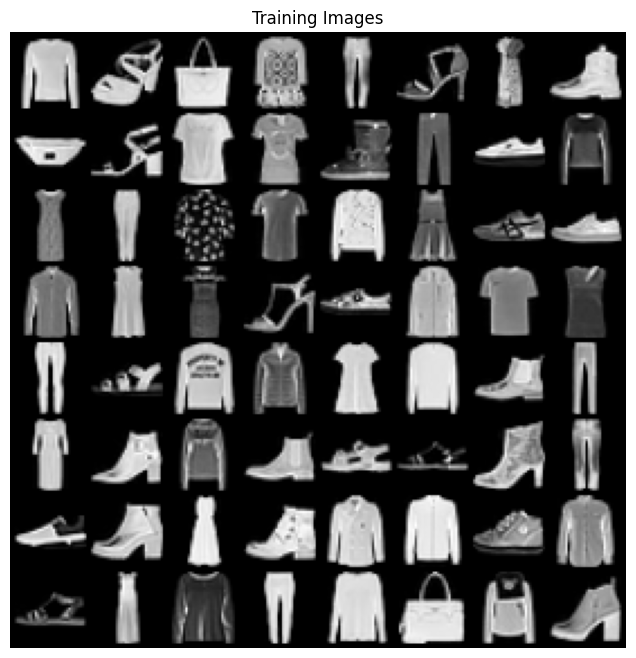

In [12]:
# Plot some training images
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## Data Distribution

In [13]:
print(train_dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [14]:
# Defining class labels for Fashion MNIST
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]

In [15]:
all_labels = [label for _, label in train_dataset]

In [16]:
all_labels[0:10]

[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]

In [17]:
# counting the number of time each label occurs:
unique_labels, label_counts = np.unique(all_labels, return_counts=True)

In [18]:
print("Output Class Distribution")
for i in range (0, len(unique_labels)):
    print(class_labels[i], unique_labels[i], ": ", label_counts[i])

Output Class Distribution
T-shirt/top 0 :  6000
Trouser 1 :  6000
Pullover 2 :  6000
Dress 3 :  6000
Coat 4 :  6000
Sandal 5 :  6000
Shirt 6 :  6000
Sneaker 7 :  6000
Bag 8 :  6000
Ankle Boot 9 :  6000


(Text(0.5, 0, 'Classes'), Text(0, 0.5, 'Number of samples'))

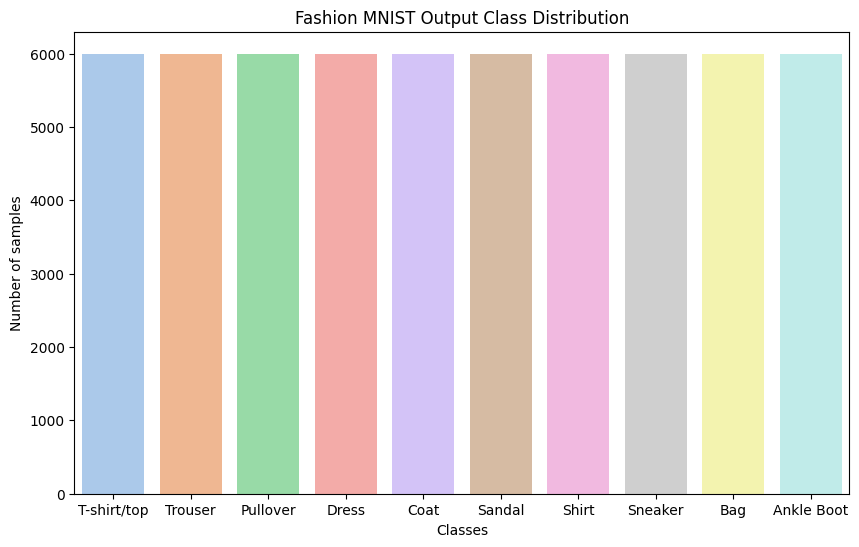

In [19]:
# plotting the above distribution
plt.figure(figsize=(10, 6))
g = sns.barplot(x=class_labels, 
            y=label_counts, 
            hue=class_labels,
            palette='pastel')
g.set_title("Fashion MNIST Output Class Distribution")
g.set_xlabel("Classes"), g.set_ylabel("Number of samples")

# GANs
## GAN Architecture

Generative adversarial networks (GANs) belong to a category of unsupervised learning algorithms. In this architecture, there are two neural networks that compete in a minimax game. The first neural network is known as a generator, which tries to create images (initially out of random noise). The second part is the discriminator, which is trained to detect whether the input image received is real or fake. These two networks are pitted against each other through an adversarial process. Initially, the generator is very bad at creating images, and the discriminator can easily distinguish between real images and fake images that is created by the generator. However, the loss at the end of the discriminator is backpropagated to the generator, and now the generator can generate images that are more realistic. Finally at one point the generator will become so good, that the discriminator will be unable to tell with more than 50% certainty if an image is real or fake. At this point, the generator neural network can be removed from this architecture and be used for generating realistic images based on the training data.
The equation for this adversarial process can be expressed as:

```
minG maxD V (D, G) = Ex∼pdata (x) [log D(x)] + Ez∼pz(z) [log(1 −D(G(z)))]
```

where:
- V (D, G): is the value function of the discriminator & generator network
- x: is the data 
- pz(z): input noise variable
- G(z): function to map the input noise into data distribution
- D(x): probability that ‘x’ came from the data rather than the generator
- The discriminator and generator play a two-player minimax game with the value function V (D, G)


The architecture of GANs can be diagrammatically represented as follows:

![GAN Architecture](./images/gan_architecture.svg)

### Error Back-propagation in GANs

Discriminator back-propagation:
![Discriminator back-propagation](./images/discriminator_backprop.svg)

Generator back-propagation:
![Generator back-propagation](./images/generator_backprop.svg)

## Problem with GANs

The issue with GANs, which was also covered in the [Conditional Generative Adversarial Nets paper](./papers/CGANs%20Paper.pdf), is that there is no control over the data (in our case images) being generated. This is exactly the problem which is being solved by Conditional GANs (cGAN).


# Conditional GAN (cGAN)

## Architecture of cGAN

The authors of the Conditional Generative Adversarial Nets paper [4] discuss how GANs can be extended to a conditional model if both the generator and the discriminator are trained on not just the input data ‘x’, but also some extra information ‘y’. Interestingly, the author mentions that ‘y’ can be the label of the data or it can be data from other modalities – if we want to generate multi-modal generative models.

![cGAn Architecture](./images/cgan_architecture.png)

Therefore, since we are providing the ‘y’ labels to the generator and the discriminator the equation changes to the following:

```
minG maxD V (D, G) = Ex∼pdata (x) [log D(x|y)] + Ez∼pz(z) [log(1 −D(G(z|y)))]
```

where:
- x: is the data 
- y: is the labels
- G(z|y): function to map the input noise into data distribution, given the ‘y’ label
- D(x|y): probability that ‘x’, given the ‘y’ label, came from the data rather than the generator


## cGAN Generator

In [12]:
# Defining Conditional Generator

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # creating an embedding for the 'y' label
        self.label_embedding = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            # block 1
            nn.Linear(nz + 10, 128),
            nn.ReLU(),

            # block 2
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.ReLU(),

            # block 3
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.ReLU(),

            # block 4
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.ReLU(),

            # block 5
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate the label embedding and image as the input
        gen_input = torch.cat((self.label_embedding(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

## cGAN Discriminator

In [13]:
# Defining Conditional Discriminator

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # creating an embedding for the 'y' label
        self.label_embedding = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)) + 10, 512), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1)
            # nn.Sigmoid()
        )
    
    def forward(self, img, labels):
        # Concatenate the label embedding and image as the input
        d_input = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_input)
        return validity
        

## Trainnig cGAN

In [14]:
# Initialize the generator & discriminator models

generator = Generator().to(device)
discriminator = Discriminator().to(device)

### Loss Function & Optimizers

For the initial model, I have decided to use the same Mean Squared Error loss function (MSELoss in PyTorch) and Adam optimizers.

There would be two optimizers, one for the generator network, and one for the discriminator network. The same parameters have been used for both **Adam optimizers with learning rate as 0.0002 and Beta1 = 0.5, and Beta2 = 0.999** 

In [23]:
# MSE Loss
adversarial_loss = nn.MSELoss()

# generator & discriminator using Adam optimizer
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

### Training Loop

In [24]:
# Helper function to save the images during training
def save_intermediate_image(n_row: int, epochs_done: int, img_list = []):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, nz))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/Image_Epoch_%d.png" % epochs_done, nrow=n_row, normalize=True)
    img_list.append(vutils.make_grid(gen_imgs, padding=2, normalize=True))

In [25]:
# Training Loop:

# saving intermediary results from training
img_list = []
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        #  Train Generator
        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, nz))))
        gen_labels = Variable(LongTensor(np.random.randint(0, 10, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        #  Train Discriminator
        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # batches_done = epoch * len(train_dataloader) + i
        
    # Display the D loss and G loss
    print(
        "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch, num_epochs, d_loss.item(), g_loss.item())
    )

    # save the D loss and G loss
    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())

    # save the image
    if epoch % sample_epoch_interval == 0:
        save_intermediate_image(n_row=10, epochs_done=epoch, img_list = img_list)

/tmp/ipykernel_1823/3369582226.py:14: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)


[Epoch 0/101] [D loss: 0.131691] [G loss: 0.630074]
[Epoch 1/101] [D loss: 0.180012] [G loss: 0.390188]
[Epoch 2/101] [D loss: 0.177972] [G loss: 0.356771]
[Epoch 3/101] [D loss: 0.215259] [G loss: 0.550780]
[Epoch 4/101] [D loss: 0.179126] [G loss: 0.410080]
[Epoch 5/101] [D loss: 0.253313] [G loss: 0.304456]
[Epoch 6/101] [D loss: 0.194891] [G loss: 0.384817]
[Epoch 7/101] [D loss: 0.180998] [G loss: 0.381909]
[Epoch 8/101] [D loss: 0.224318] [G loss: 0.214104]
[Epoch 9/101] [D loss: 0.215082] [G loss: 0.345224]
[Epoch 10/101] [D loss: 0.241796] [G loss: 0.247894]
[Epoch 11/101] [D loss: 0.229691] [G loss: 0.295040]
[Epoch 12/101] [D loss: 0.216963] [G loss: 0.316456]
[Epoch 13/101] [D loss: 0.198631] [G loss: 0.314741]
[Epoch 14/101] [D loss: 0.196520] [G loss: 0.362803]
[Epoch 15/101] [D loss: 0.206168] [G loss: 0.283940]
[Epoch 16/101] [D loss: 0.261703] [G loss: 0.314799]
[Epoch 17/101] [D loss: 0.212831] [G loss: 0.387272]
[Epoch 18/101] [D loss: 0.252164] [G loss: 0.393283]
[Ep

### Saving Trained Models

In [15]:
G_MODEL_PATH = './models/generator_nn.pth'
D_MODEL_PATH = './models/discriminator_nn.pth'

# creating a directory
os.makedirs('./models', exist_ok=True)

torch.save(generator.state_dict(), G_MODEL_PATH)
torch.save(discriminator.state_dict(), D_MODEL_PATH)

### Loading Trained Model 

In [17]:
generator = Generator()
generator.load_state_dict(torch.load(G_MODEL_PATH))
generator.to(device)
generator.eval()
print(generator)

discriminator = Discriminator()
discriminator.load_state_dict(torch.load(D_MODEL_PATH))
discriminator.to(device)
discriminator.eval()
print(discriminator)

Generator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=1024, out_features=1024, bias=True)
    (12): Tanh()
  )
)
Discriminator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=1034, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (

### Generator & Discriminator Loss

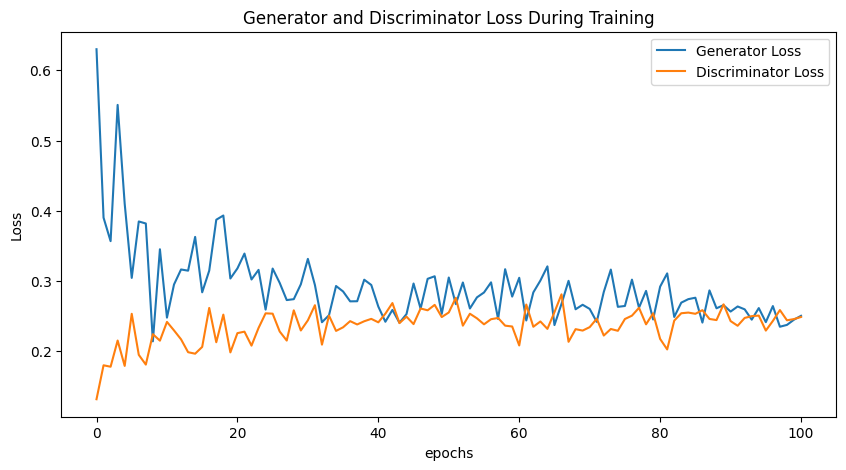

In [30]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator Loss")
plt.plot(D_losses,label="Discriminator Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Model Evaluation
### Visualizing Generated Images

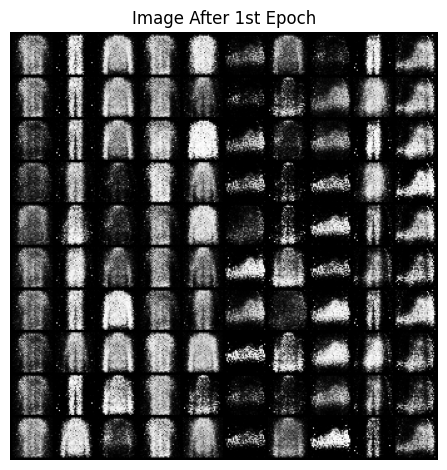

In [31]:
# Displaying the first image
first_image = Image.open('./images/Image_Epoch_0.png')
plt.imshow(first_image, cmap='gray')
plt.axis("off")
plt.title("Image After 1st Epoch")
plt.tight_layout()
plt.show()


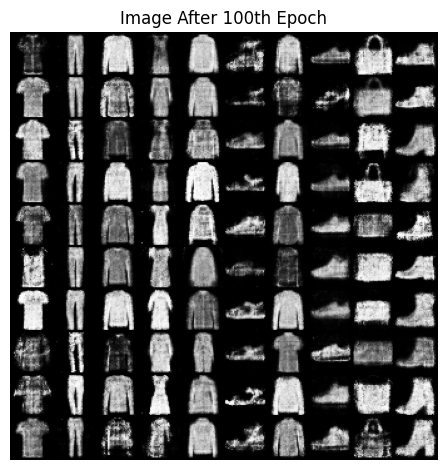

In [32]:
# Displaying the last image
last_epoch = Image.open('./images/Image_Epoch_100.png')
plt.imshow(last_epoch, cmap='gray')
plt.axis("off")
plt.title("Image After 100th Epoch")
plt.tight_layout()
plt.show()


In [33]:
# writing the above code in a method:
def display_generated_image(epoch_number: int):
    image_at_epoch = Image.open(f'./images/Image_Epoch_{epoch_number}.png')
    plt.imshow(image_at_epoch, cmap='gray')
    plt.axis("off")
    if(epoch_number == 0):
        epoch_number += 1 # to display that it is after 1st epoch
    plt.title(f"Image After {epoch_number} Epoch(s)")
    plt.tight_layout()
    plt.show()


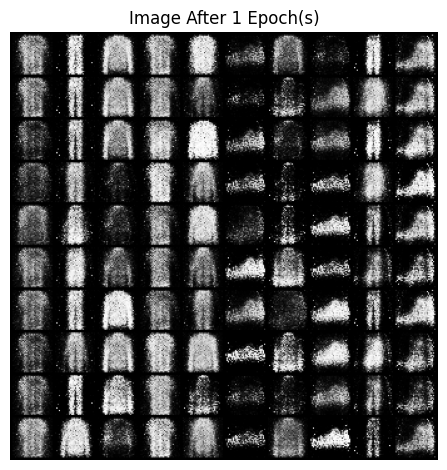

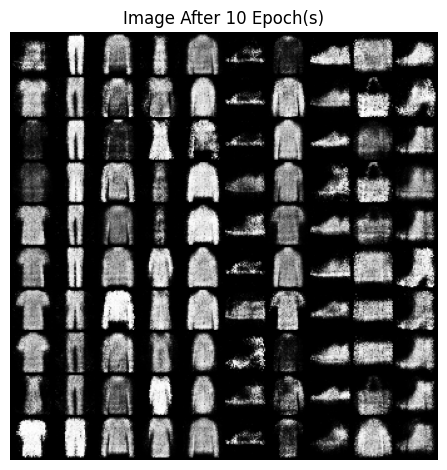

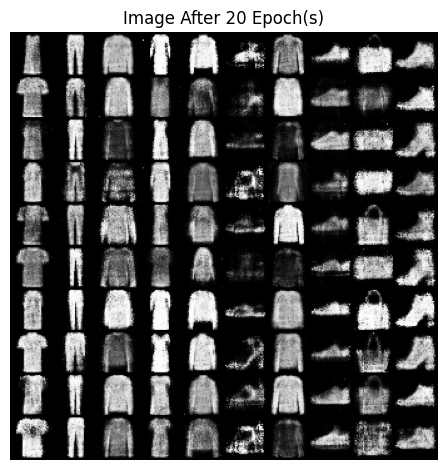

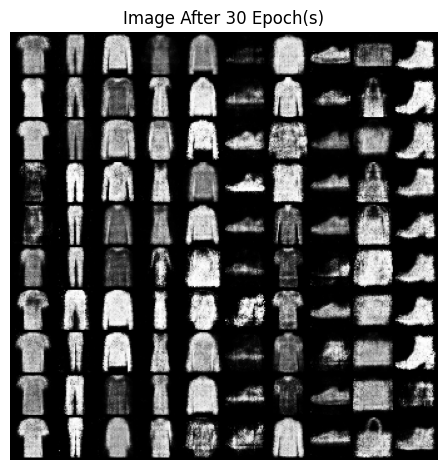

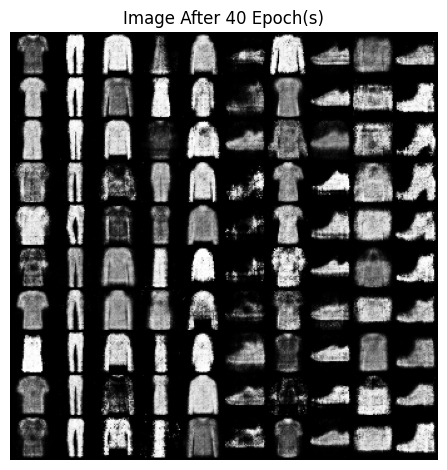

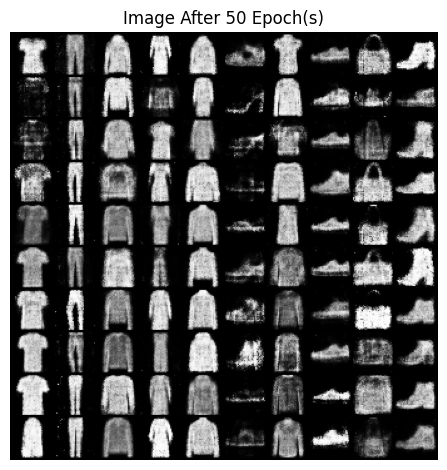

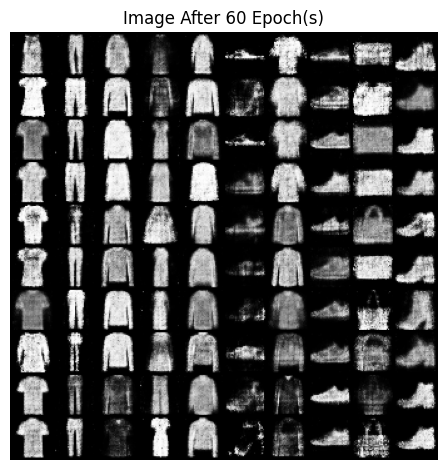

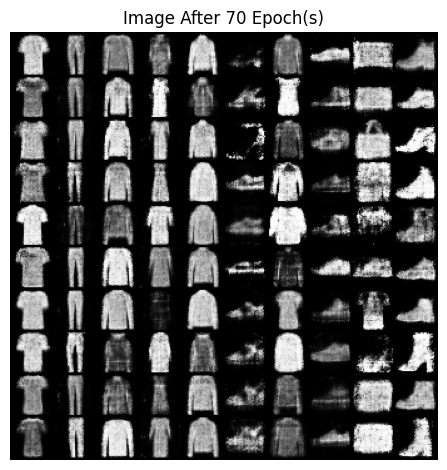

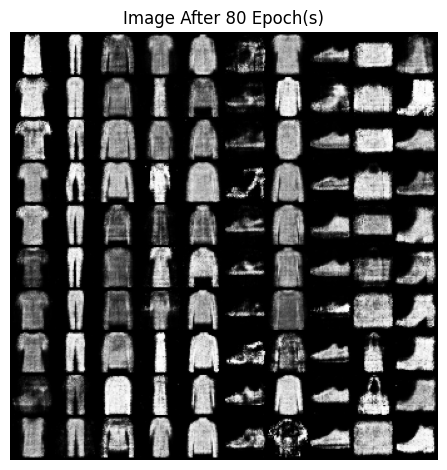

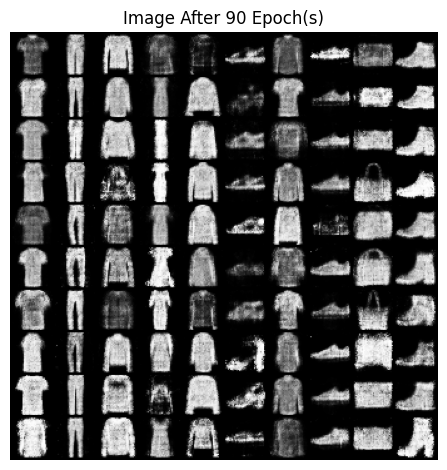

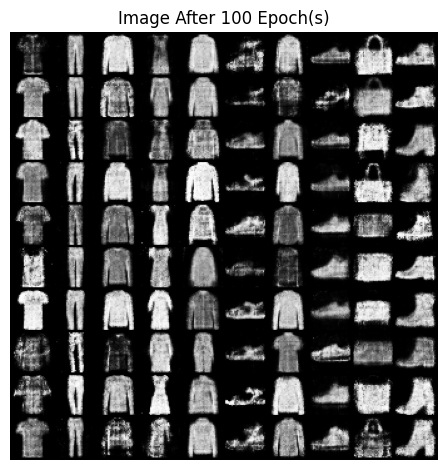

In [34]:
# displaying the saved images:
for i in range(0, 101, 10):
    display_generated_image(i)

In [35]:
import imageio

# creating an animated GIF
def create_gif(output_gif="./images/generated_images.gif", duration=2):
    images = []
    image_files = []

    for epoch_number in range(0, 101, 10):
        image_files.append(f'./images/Image_Epoch_{epoch_number}.png')

    for filename in image_files:
        images.append(imageio.imread(filename))
        # if filename.endswith(".png"):
        #     img_path = os.path.join(image_folder, filename)
        #     images.append(imageio.imread(img_path))

    # Save as GIF
    imageio.mimsave(output_gif, images, duration=duration)
    print(f"GIF saved as {output_gif}")

create_gif()

GIF saved as ./images/generated_images.gif


/tmp/ipykernel_1823/3704444089.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


## Conditioning GAN to Generate Specific Images

In [36]:
# Generating images for a specific label using the trained Generator.
def generate_specific_images(generator, label, num_samples=1, device="cuda"):
    
    generator.to(device)
    generator.eval()  # Set generator to evaluation mode

    # Generate random noise (z)
    noise = torch.randn(num_samples, nz, device=device)

    # Convert label to tensor and send to device
    labels = torch.full((num_samples,), label, dtype=torch.long, device=device)

    # Generate images
    with torch.no_grad():  # No gradient tracking for inference
        generated_images = generator(noise, labels)

    # Convert images to CPU and display
    generated_images = generated_images.cpu().detach().numpy()

    # Display the images
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        axs[i].imshow(generated_images[i][0], cmap="gray")  # Assuming single-channel grayscale
        axs[i].axis("off")
    plt.show()

### Generating T-shirts/ tops

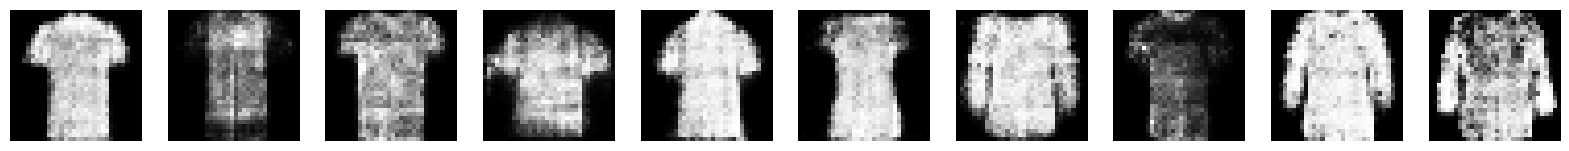

In [37]:
generate_specific_images(generator, label=0, num_samples=10, device="cuda")

### Generating Trousers

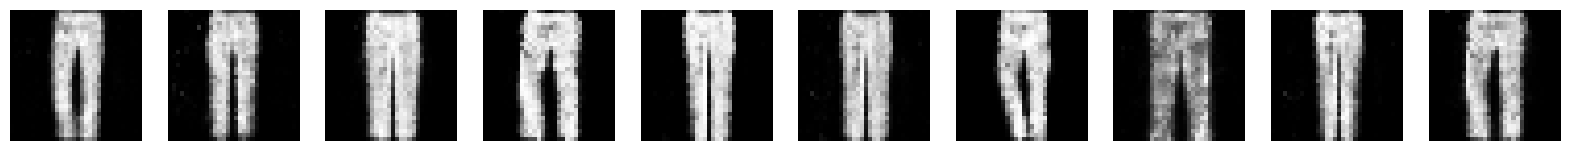

In [38]:
generate_specific_images(generator, label=1, num_samples=10, device="cuda")

### Generating Pullovers

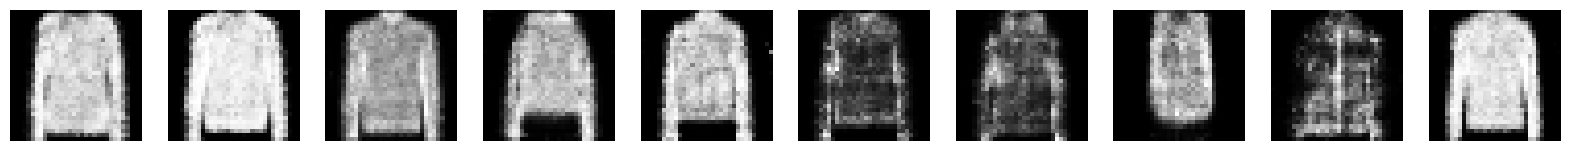

In [39]:
generate_specific_images(generator, label=2, num_samples=10, device="cuda")

### Generating Dresses

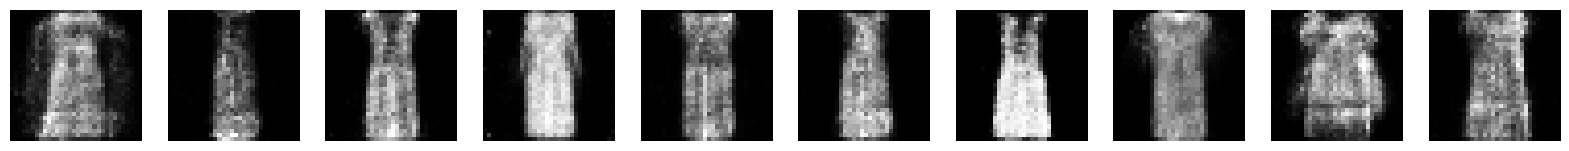

In [40]:
generate_specific_images(generator, label=3, num_samples=10, device="cuda")

### Generating Coat

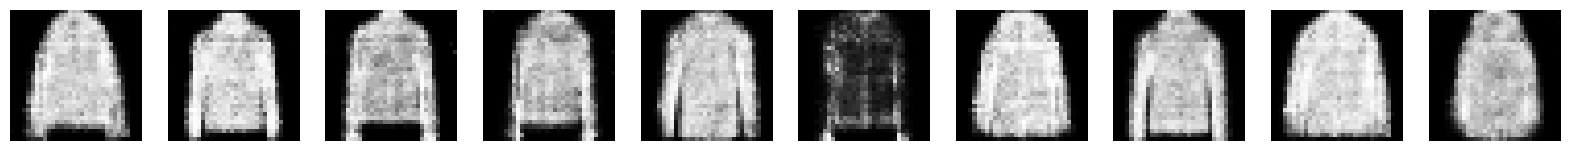

In [41]:
generate_specific_images(generator, label=4, num_samples=10, device="cuda")

### Generating Sandals

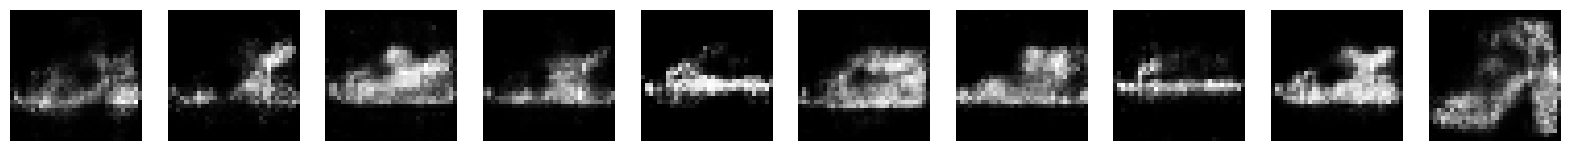

In [42]:
generate_specific_images(generator, label=5, num_samples=10, device="cuda")

### Generating Shirts

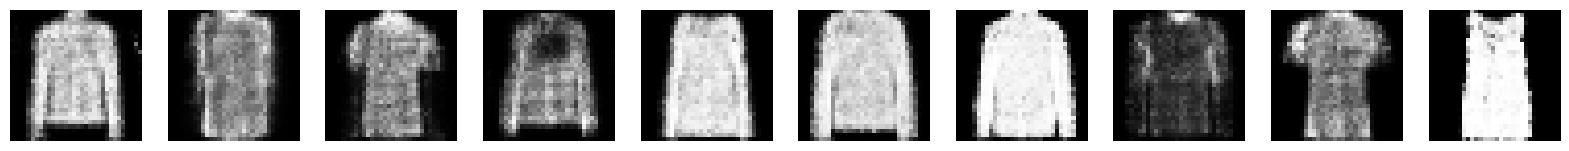

In [43]:
generate_specific_images(generator, label=6, num_samples=10, device="cuda")

### Generating Sneakers

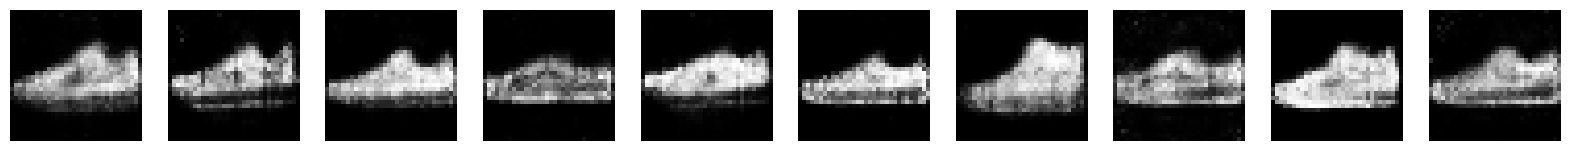

In [44]:
generate_specific_images(generator, label=7, num_samples=10, device="cuda")

### Generating Bags

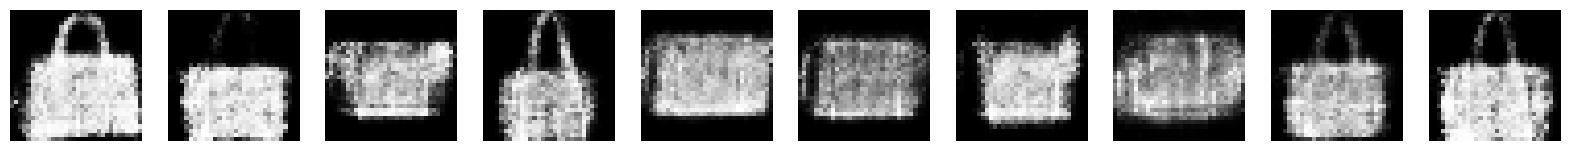

In [45]:
generate_specific_images(generator, label=8, num_samples=10, device="cuda")

### Generating Ankle Boots

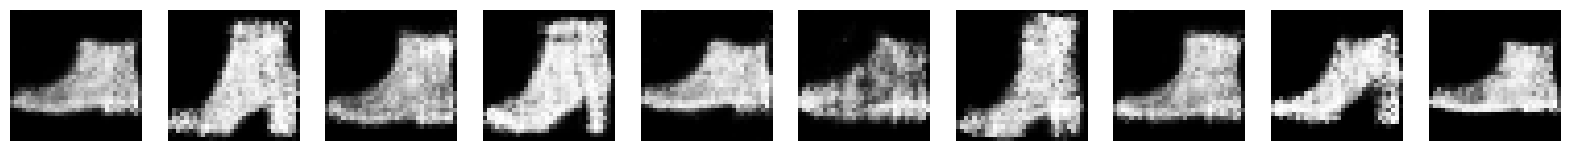

In [46]:
generate_specific_images(generator, label=9, num_samples=10, device="cuda")

## Conclusion

This report shows how we can solve one major issue with traditional GANs- the controllability of the output. Through Conditional GANs, we have successfully trained the discriminator and the generators to take the input ‘y’ label as an input which is used to help generate specific types of image outputs.